<a href="https://colab.research.google.com/github/kamalmalikofficial/AIMS-softwarework/blob/main/CLIP_%2B_fastrnn(API_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/openai/CLIP.git ftfy regex tqdm


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4lafakh3
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4lafakh3
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install pillow

Loading CLIP...
Loading detector (Faster R-CNN)...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


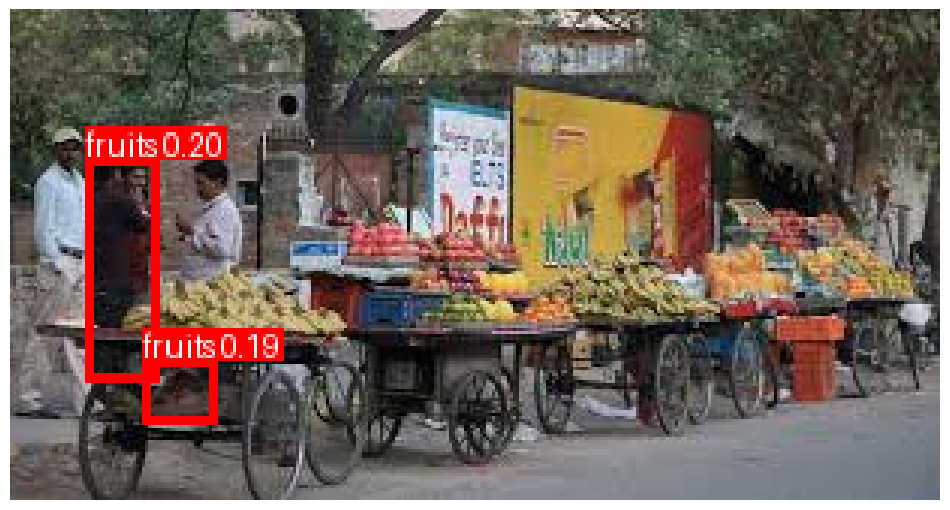

Detected boxes (x1,y1,x2,y2) and CLIP sim scores:
(25, 49, 49, 123) 0.203
(44, 116, 68, 137) 0.191


In [ ]:
import torch
import clip
from PIL import Image, ImageDraw, ImageFont
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Config
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
DETECTOR_SCORE_THRESH = 0.6   # keep detector boxes above this
CLIP_SIM_THRESH = 0.35        # keep CLIP-matched boxes above this (cosine similarity)
TOP_K = 2                    # how many top boxes to show (after CLIP scoring)
CLIP_MODEL = "ViT-B/32"       # model name for CLIP
# -------------------------

# Utilities
def load_image(path):
    return Image.open(path).convert("RGB")

def draw_boxes_pil(image, boxes, labels=None, scores=None, width=3):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 16)
    except:
        font = ImageFont.load_default()

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline="red", width=width)
        text = ""
        if labels is not None:
            text += str(labels[i])
        if scores is not None:
            text += f" {scores[i]:.2f}"
        if text:
            # Get text width & height
            if hasattr(draw, "textbbox"):  # Pillow ≥ 8.0
                tw, th = draw.textbbox((0, 0), text, font=font)[2:]
            else:  # Fallback for older Pillow
                tw, th = font.getsize(text)
            # Draw background rectangle
            draw.rectangle([x1, y1 - th, x1 + tw, y1], fill="red")
            draw.text((x1, y1 - th), text, fill="white", font=font)
    return image

# Load CLIP
print("Loading CLIP...")
clip_model, clip_preprocess = clip.load(CLIP_MODEL, device=device, jit=False)
clip_model.eval()

# Load detector
print("Loading detector (Faster R-CNN)...")
detector = fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
detector.to(device)
detector.eval()

# transform for detector (torchvision expects tensors)
detector_transform = T.Compose([
    T.ToTensor()
])

# Main function: given image path & prompt, return boxes
def find_and_draw(image_pil, prompt, visualize=True):
    # Prepare image for detector
    img_tensor = detector_transform(image_pil).to(device)
    with torch.no_grad():
        det_out = detector([img_tensor])[0]   # dict with boxes, labels, scores

    boxes = det_out['boxes'].cpu()   # Nx4
    det_scores = det_out['scores'].cpu()
    # filter by detector score threshold
    keep_idx = (det_scores >= DETECTOR_SCORE_THRESH).nonzero(as_tuple=False).squeeze(1)
    if keep_idx.numel() == 0:
        print("No detector boxes above threshold.")
        return image_pil

    boxes = boxes[keep_idx].numpy()
    det_scores = det_scores[keep_idx].numpy()

    # Prepare crops and run CLIP on each crop
    crops = []
    crop_boxes = []
    for b in boxes:
        x1, y1, x2, y2 = list(map(int, b))
        # ensure valid box
        if x2 <= x1 or y2 <= y1:
            continue
        crop = image_pil.crop((x1, y1, x2, y2)).convert("RGB")
        crops.append(crop)
        crop_boxes.append((x1, y1, x2, y2))

    if len(crops) == 0:
        print("No valid crops found.")
        return image_pil

    # CLIP preprocessing: convert crops to tensors
    clip_inputs = torch.stack([clip_preprocess(crop) for crop in crops]).to(device)  # Bx3xHxW
    text_tokens = clip.tokenize([prompt]).to(device)  # 1xK

    with torch.no_grad():
        image_features = clip_model.encode_image(clip_inputs)  # BxD
        text_features = clip_model.encode_text(text_tokens)    # 1xD

        # normalize
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # cosine similarities (B,1)
        sims = (image_features @ text_features.T).squeeze(1).cpu().numpy()

    # Combine with detector scores optionally (weighted). For simplicity, use CLIP sims.
    # Keep boxes with sim > CLIP_SIM_THRESH
    selected = []
    for i, sim in enumerate(sims):
        if sim >= CLIP_SIM_THRESH:
            selected.append((i, sim))

    if len(selected) == 0:
        # if nothing above threshold, show top-K by similarity
        topk_idx = np.argsort(-sims)[:TOP_K]
        selected = [(int(i), float(sims[i])) for i in topk_idx]

    # Sort selected by similarity desc and choose up to TOP_K
    selected = sorted(selected, key=lambda x: -x[1])[:TOP_K]
    sel_boxes = [crop_boxes[i] for i, s in selected]
    sel_sims = [s for i, s in selected]

    # Draw
    out_img = image_pil.copy()
    labels = [prompt]*len(sel_boxes)
    scores = sel_sims
    out_img = draw_boxes_pil(out_img, sel_boxes, labels=labels, scores=scores, width=3)

    if visualize:
        plt.figure(figsize=(12,8))
        plt.imshow(out_img)
        plt.axis("off")
        plt.show()

    return out_img, sel_boxes, sel_sims

# -------------------------
# Example usage
# -------------------------
if __name__ == "__main__":
    # Upload your image path here (or use files.upload in Colab)
    image_path = "17.jpeg"  # replace with your image
    # Optionally in Colab: from google.colab import files; files.upload()
    image = load_image(image_path)

    prompt = "fruits"   # change to your text prompt
    out_img, boxes, sims = find_and_draw(image, prompt, visualize=True)

    print("Detected boxes (x1,y1,x2,y2) and CLIP sim scores:")
    for b, s in zip(boxes, sims):
        print(b, f"{s:.3f}")